In [4]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=a7936ff91182919a54283b412095666dd2a670cf3f75c4c5e3279a551ba9b688
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.4 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [50]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [6]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [7]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


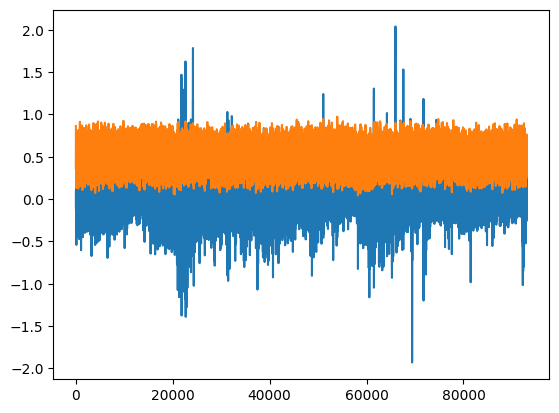

In [8]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [9]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [10]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [11]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [12]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [13]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [14]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [16]:
winner = p.run(eval_genomes,10)


 ****** Running generation 10 ****** 

Population's average fitness: -2.04904 stdev: 39.43294
Best fitness: 174.45670 - size: (4, 1) - species 1 - id 637
Average adjusted fitness: 0.517
Mean genetic distance 1.620, standard deviation 0.571
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.232 sec (2.195 average)

 ****** Running generation 11 ****** 

Population's average fitness: -13.15433 stdev: 43.63468
Best fitness: 122.61802 - size: (4, 1) - species 1 - id 1526
Average adjusted fitness: 0.486
Mean genetic distance 1.594, standard deviation 0.578
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.330 sec (2.237 average)

 ****** Running generation 12 ****** 

Population's average fitness: -15.43902 stdev: 40.51127
Best fitness: 57.59000 - size: (4, 1) - species 1 - id 1526
Average adjusted fitness: 0.587
Mean genetic distance 1.689, standard deviation 0.524
Population of 150 members in 1 species
Total extinctions: 0
Generati

In [47]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [18]:
run_env_loop(net,80000,True)

[1.         0.21895992 0.         0.21895992]
0
[ 1.         -0.13985449  0.         -0.13985449]
0.21895992116917998
[ 1.         -0.11992821  0.         -0.11992821]
-0.1398544902270313
[ 1.         -0.53178845  0.         -0.53178845]
-0.11992821352884313
[ 1.         -0.29274556  0.         -0.29274556]
-0.5317884517234797
[1.         0.56479609 0.         0.56479609]
-0.2927455563583783
[1.        0.1258476 0.        0.1258476]
0.5647960883101033
[ 1.         -0.29258168  0.         -0.29258168]
0.1258475988398043
[-1.          1.82626916  0.          1.82626916]
-0.2925816836181545
[-1.          0.29947671  0.          0.29947671]
1.8262691584931812
[-1.          0.91250084  0.          0.91250084]
0.29947670938120163
[-1.          0.68699198  0.          0.68699198]
0.9125008408824559
[-1.          0.82794031  0.          0.82794031]
0.686991976774094
[-1.         -0.24703461  0.         -0.24703461]
0.8279403145300622
[-1.          0.04700826  0.          0.04700826]
-0.2470346

107.59485483247505

In [70]:
node = winner.nodes

node_list = []
letter = dict()
count = 0
for index, node in node.items():
    letter[index] = string.ascii_uppercase[count]
    node_name = letter[index]
    activation = node.activation
    bias = node.bias
    front = node_name + " = " + activation + "("
    count += 1
    node_list.append((front,bias))

print(node_list)

[('A = clamped(', -0.11441136078292324), ('B = abs(', -2.0208280055147525), ('C = relu(', 0.2740460486162727), ('D = relu(', -2.3615975503654325), ('E = relu(', 0.3498863846071416), ('F = relu(', 0.3844528491912358)]


In [108]:
conec = winner.connections


def get_weights(connections, node_name):
    node_from_list = []
    weight_list = []

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                weight_list.append(weight)

    return(weight_list)




print(get_weights(conec,'D'))

[4.068317009891944, 0.06349468178725404, 1.5752637899790252]


In [44]:
combined_dict = {}

for letter, string in key_list:
    if letter not in combined_dict:
        combined_dict[letter] = string
    else:
        combined_dict[letter] += string

combined_list = list(combined_dict.items())

print(combined_list)

[('D', 'P2 * 4.068317009891944 + P4 * 0.06349468178725404 + F * 1.5752637899790252 + '), ('C', 'P5 * -0.35750870976560806 + '), ('F', 'P5 * 1.0 + '), ('E', 'B * -1.5764271105388825 + ')]


In [ ]:
print(node)

DefaultNodeGene(key=3, bias=1.5268048091598456, response=1.0, activation=sigmoid, aggregation=sum)


In [ ]:


for index, node in node.items():
    neuron_letter = str(values[index]) + " = "
    activation = "AF."+str(node.activation)+"("
    bias = str(node.bias)



    output = neuron_letter + activation
    print(output)

#negative number for connections implies the inputs
#all other numbers implie nodes

AttributeError: 'DefaultNodeGene' object has no attribute 'items'